# Model Testing

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 12/06/2025   | Martin | Create  | Baseline model with Decision Tree and HistGradientBoosting regressor | 
| 24/06/2025   | Martin | Update  | Completed baseline models. Started on ARIMA models | 
| 02/07/2025   | Martin | Update  | Completed ARIMA model. Exploring NN models | 
| 08/07/2025   | Martin | Update  | Completed TFT model. Did not make full prediction as it does not scale well for 500k+ samples | 

__Exploration Scores__

- Baseline (DecisionTree | Full Data): -0.003280
- Baseline (HistGradientBoosting | Full Data): 0.054610
- Baseline (LightGBM | Full Data): 0.023996
- Time-series (ARIMA | Feat Impt 45 Data): -0.019896
- Optuna (LightGBM | PCA 120 Data) : 0.0789946

__Submitted Scores__

- Baseline (LightGBM | Full Data): 0.04734

# Content

* [Baseline Models](#baseline-models)
* [ARIMA Models](#arima-models)
* [Temporal Fusion Transformer](#temporal-fusion-transformer)
* [Make Predictions](#make-predictions)

# Baseline Models

Baseline model serves as the starting point for all future scores. Using a Decision Tree, HistGradientBoostingRegressor, LightGBM with KFold Cross Validation together with entire dataset for testing.

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import wandb

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import KFold
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# from lightgbm import LGBMRegressor

from scipy.stats import pearsonr

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: minimartzz to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# Global parameters
PROJ_NAME = "drw_cryto_market"

In [4]:
df = pl.read_csv("data/clean/orig_plus.csv")

# Remove timestamp
df = df.drop('timestamp')

In [5]:
df.head()

bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,…,X863,X864,X865,X866,X867,X868,X869,X870,X871,X872,X873,X874,X875,X876,X877,X878,X879,X880,X881,X882,X883,X884,X885,X886,X887,X888,X889,X890,label,bair,moi,ofr,lpr,obs,vwoi,va,obrsi
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
15.283,8.425,176.405,44.984,221.389,0.121263,-0.41769,0.005399,0.125948,0.058359,0.027359,0.03578,0.068219,1.034825,-0.029575,0.327805,0.485823,0.668596,0.617389,0.770037,0.857631,1.754456,0.572503,0.883229,0.58567,0.816321,0.529973,0.508244,0.448616,1.341892,1.406392,0.953631,1.183991,1.474789,0.774389,0.660586,0.269043,…,0.21857,0.0,1.728155,0.62414,0.0,-0.051211,0.0,0.0,0.0,0.0,0.691754,0.242124,2.096157,3.369195,0.244667,0.286611,0.722679,0.901931,1.000007,1.925423,1.847943,0.005676,0.190791,0.369691,0.37763,0.210153,0.159183,0.530636,0.562539,1.814006,3.921505,0.59362,3.589058,138.279,0.59362,626.407,57.874677
38.59,2.336,525.846,321.95,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,-0.183488,0.150526,0.308421,0.492232,0.529787,0.682958,0.770965,1.686504,0.273357,0.591695,0.442391,0.674792,0.460741,0.439681,0.380399,1.304113,1.003783,0.776628,1.015943,1.312735,0.696895,0.584217,0.231104,…,0.088014,0.0,1.665698,0.622775,0.0,-0.079621,0.0,0.0,0.0,0.0,0.691665,0.242091,2.46103,4.127584,0.321394,0.31246,0.746452,0.912371,1.003153,1.928569,1.849468,0.005227,0.18466,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686,16.519692,1.633316,0.240501,1.74055,240.15,0.240501,626.407,57.874677
0.442,60.25,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,-0.261779,0.044571,0.200608,0.384558,0.476229,0.629848,0.718232,1.656707,0.140156,0.457268,0.376524,0.610116,0.429751,0.409316,0.350359,1.28325,0.760801,0.670816,0.917205,1.219124,0.653355,0.541739,0.210095,…,-0.147363,0.0,1.666893,0.621414,0.0,-0.080427,0.0,0.0,0.0,0.0,0.691674,0.242093,2.493249,4.182112,0.326701,0.314636,0.746681,0.911129,1.002502,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505,0.007336,1.167619,0.077329,0.812073,-36.95,0.077329,-552.2,57.874677
4.865,21.016,335.742,124.963,460.705,0.072944,-0.43659,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,-0.535845,-0.273947,-0.124959,0.056438,0.311539,0.465377,0.554022,1.663491,0.152084,0.468778,0.383696,0.618529,0.435326,0.415523,0.356895,1.319538,0.955549,0.789646,1.044941,1.353001,0.72392,0.613462,0.246212,…,-0.09459,0.0,1.735322,0.620057,0.0,-0.094702,0.0,0.0,0.0,0.0,0.69121,0.24193,2.525526,4.292975,0.350791,0.32357,0.753829,0.913363,1.002985,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703,0.23149,2.686731,0.457514,2.33326,194.628,0.457514,165.109,57.874677
27.158,3.451,98.411,44.407,142.818,0.17382,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,-0.430945,-0.205298,-0.062118,0.117266,0.341493,0.495591,0.584519,1.668419,0.156177,0.472732,0.3871,0.623192,0.439034,0.419868,0.361572,1.324595,0.90546,0.78375,1.047708,1.36188,0.732001,0.622712,0.251095,…,0.162221,0.0,1.712096,0.618703,0.0,-0.091884,0.0,0.0,0.0,0.0,0.691207,0.241928,2.52443,4.306694,0.335599,0.31907,0.747533,0.908904,1.001286,1.927084,1.84895,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452,7.869603,2.216115,0.378132,2.623783,77.711,0.378132,-317.887,57.874677


In [6]:
# Split into X and y
y = df['label'].to_numpy()
X = df.drop('label').to_numpy()

# Standardise the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((525887, 882), (525887,))

Change configuration according to model used

In [ ]:
# Define model configuration
config = {
  "num_kfold_splits": 7,
  "boosting_type": "gbdt",
  "num_leaves": 31,
  "max_depth": -1,
  "learning_rate": 0.1,
  "n_estimators": 100,
  "reg_alpha": 0,
  "reg_lambda": 0
}

# Define wandb object
run = wandb.init(
  project=PROJ_NAME,
  notes="Light Gradient Boosting with original data + additional features",
  tags=["baseline", "orig_plus"],
  config=config
)

In [20]:
# Create KFold cross validation and train
kf = KFold(n_splits=run.config['num_kfold_splits'])

split_idx = {}
scores = []

for i, (train_idx, test_idx) in enumerate(kf.split(X)):
  print(f"Fold {i+1}")

  # Split data and store training indices
  train_X, train_y = X[train_idx], y[train_idx]
  test_X, test_y = X[test_idx], y[test_idx]
  split_idx[f"fold_{i+1}"] = train_idx

  # Train model
  # model = DecisionTreeRegressor(
  #   max_depth=run.config['max_depth'],
  #   random_state=43
  # )

  # model = HistGradientBoostingRegressor(
  #   loss=run.config['loss'],
  #   learning_rate=run.config['learning_rate'],
  #   max_iter=run.config['max_iter'],
  #   max_depth=run.config['max_depth'],
  #   l2_regularization=run.config['l2_regularization']
  # )

  model = LGBMRegressor(
    boosting_type=run.config['boosting_type'],
    num_leaves=run.config['num_leaves'],
    max_depth=run.config['max_depth'],
    learning_rate=run.config['learning_rate'],
    n_estimators=run.config['n_estimators'],
    reg_alpha=run.config['reg_alpha'],
    reg_lambda=run.config['reg_lambda']
  )
  model.fit(train_X, train_y)

  # Prediction on val set
  results = model.predict(test_X)

  # Scoring and logging
  pearson_corr = pearsonr(results, test_y).statistic
  metrics = {
    'pearson_corr': pearson_corr,
    'mae': mean_absolute_error(test_y, results),
    'mse': mean_squared_error(test_y, results),
    'r2': r2_score(test_y, results),
  }
  run.log({ **metrics })
  scores.append(pearson_corr)

  print(f"Pearson Coefficient Score: {pearson_corr}")
  print("---------------------------")

print(f"Average Pearson Correlation Score: {np.mean(pearson_corr)}")


Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.563921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223363
[LightGBM] [Info] Number of data points in the train set: 450760, number of used features: 876
[LightGBM] [Info] Start training from score 0.039411


d:\Software\venv\py311_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Pearson Coefficient Score: 0.05302349659897179
---------------------------
Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.484957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223363
[LightGBM] [Info] Number of data points in the train set: 450760, number of used features: 876
[LightGBM] [Info] Start training from score 0.043508


d:\Software\venv\py311_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Pearson Coefficient Score: 0.1564405035878033
---------------------------
Fold 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.475298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223377
[LightGBM] [Info] Number of data points in the train set: 450760, number of used features: 876
[LightGBM] [Info] Start training from score 0.037446


d:\Software\venv\py311_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Pearson Coefficient Score: 0.04456215794940085
---------------------------
Fold 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.522840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223368
[LightGBM] [Info] Number of data points in the train set: 450760, number of used features: 876
[LightGBM] [Info] Start training from score 0.048383


d:\Software\venv\py311_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Pearson Coefficient Score: -0.02082677114586489
---------------------------
Fold 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.546718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223364
[LightGBM] [Info] Number of data points in the train set: 450760, number of used features: 876
[LightGBM] [Info] Start training from score 0.025289


d:\Software\venv\py311_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Pearson Coefficient Score: 0.09251158013259256
---------------------------
Fold 6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.531671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223367
[LightGBM] [Info] Number of data points in the train set: 450761, number of used features: 876
[LightGBM] [Info] Start training from score 0.031455


d:\Software\venv\py311_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Pearson Coefficient Score: 0.11015414436875745
---------------------------
Fold 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.563751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223370
[LightGBM] [Info] Number of data points in the train set: 450761, number of used features: 876
[LightGBM] [Info] Start training from score 0.027389
Pearson Coefficient Score: 0.0239964933769129
---------------------------
Average Pearson Correlation Score: 0.0239964933769129


d:\Software\venv\py311_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [21]:
run.finish()

mae,▃▁▁▂▃▅█
mse,▄▁▁▅▅▄█
pearson_corr,▄█▄▁▅▆▃
r2,▅█▆▄▇▆▁
mae,0.814
mse,1.34892
pearson_corr,0.024
r2,-0.27143


---

# ARIMA Models



In [4]:
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [5]:
df = pl.read_csv("data/clean/perm_impt_45.csv")

# Convert timestamp column to datetime
df = df.with_columns(
  pl.col('timestamp').str.to_datetime("%Y-%m-%dT%H:%M:%S%.f")
)

# Optional: if don't need the timestamp columns
# df = df.drop('timestamp')

In [6]:
df.head()

X856,X392,X841,X853,X119,X303,X464,X331,X430,X847,X669,X680,X66,X684,X285,X215,X428,X727,X37,X794,X696,X469,X338,X376,X30,X442,X447,X32,X842,X756,X844,X525,X630,X752,X804,X854,X441,X679,X167,X219,X217,X458,X582,X591,X218,X39,X332,X380,X639,X882,X611,X96,X444,timestamp,label
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],f64
-0.216525,-0.353185,-0.423595,1.9140625,0.310967,-0.457683,-0.125618,0.251609,0.446867,0.0,0.018343,0.170473,0.076962,0.127396,0.274997,-0.213641,-1.432247,-0.301155,0.813826,-0.873615,0.323195,0.006864,-0.255793,-0.076789,0.774389,-0.00631,0.028281,0.269043,-0.109558,-0.559771,0.044788,0.919644,0.000083,-1.008644,-0.502156,0.2734375,0.055446,-0.090873,1.271148,-0.503227,-0.981975,-0.090238,0.0,0.0,-0.734477,0.966243,-0.294632,-0.459683,0.000206,1.925423,1.064323,0.505276,-0.142546,2023-03-01 00:00:00,0.562539
-0.180112,-0.531629,-0.438066,1.914019,0.305827,-0.4539,-0.117516,0.250215,0.3553,0.0,0.018242,0.17,0.071997,0.127043,0.267643,-0.154672,-1.437668,-0.289504,0.799181,0.447717,0.322746,0.032822,-0.269892,-0.053741,0.696895,0.013964,0.069297,0.231104,-0.129503,-0.579775,-0.002808,0.8824,0.000078,-1.047378,-0.256451,0.273481,0.094619,-0.090621,1.264105,-0.492606,-0.94019,-0.080306,0.0,0.0,-0.713441,0.953242,-0.322576,-0.473216,0.000199,1.928569,1.064323,0.504575,-0.135499,2023-03-01 00:01:00,0.533686
-0.265966,-0.434969,-0.446503,1.913976,0.300772,-0.458549,-0.115947,0.248829,0.356842,0.0,0.018141,0.169529,0.067352,0.12669,0.273948,-0.145909,-1.435673,-0.288898,0.80181,0.963839,0.322298,0.035882,-0.260954,-0.073398,0.653355,0.018576,0.076417,0.210095,-0.13787,-0.607837,-0.047201,0.877156,0.000073,-1.102166,-0.153923,0.273524,0.102437,-0.090369,1.257102,-0.491039,-0.933071,-0.077748,0.0,0.0,-0.710102,0.952246,-0.304434,-0.471904,0.000192,1.928047,1.047469,0.503875,-0.133705,2023-03-01 00:02:00,0.546505
-0.322244,-0.355884,-0.442895,1.913932,0.295801,-0.446581,-0.115355,0.242121,0.308452,0.0,0.01804,0.169059,-0.297614,0.126339,0.250026,-0.086529,-1.43368,-0.235724,0.842954,0.608735,0.321851,0.035096,-0.24887,-0.039039,0.72392,0.019123,0.074441,0.246212,-0.160691,-0.627782,-0.159998,0.871911,0.000068,-1.140659,-0.173282,0.273568,0.102133,-0.090119,1.250137,-0.480628,-0.891216,-0.075203,0.0,0.0,-0.689236,1.003724,-0.280059,-0.459235,0.000186,1.928621,1.044134,0.487659,-0.133251,2023-03-01 00:03:00,0.357703
-0.369625,-0.291178,-0.433274,1.913889,0.290911,-0.441609,-0.111959,0.24078,0.35407,0.0,0.01794,0.16859,-0.278413,0.125988,0.255728,-0.070527,-1.43169,-0.234088,0.830856,0.460154,0.321404,0.044307,-0.24007,-0.03942,0.732001,0.03146,0.097464,0.251095,-0.151633,-0.629221,-0.160863,0.866667,0.000064,-1.142112,-0.192536,0.273611,0.125238,-0.089869,1.243211,-0.477725,-0.878711,-0.072078,0.0,0.0,-0.683203,0.993904,-0.262309,-0.457961,0.00018,1.927084,1.019605,0.486982,-0.128862,2023-03-01 00:04:00,0.362452


In [7]:
VALID_PERC = 0.2
SEED = 43

In [8]:
# Extract the last p% of columns as validation set
np.random.seed(SEED)
num_valid = int(len(df) * VALID_PERC)

# Convert to numpy arrays
y = df['label'].to_numpy()
dt = df['timestamp'].to_numpy()
X = df.drop(['label', 'timestamp']).to_numpy()

# Subset into train valid
X_train, y_train, dt_train = X[:-num_valid], y[:-num_valid], dt[:-num_valid]
X_valid, y_valid, dt_valid = X[-num_valid:], y[-num_valid:], dt[-num_valid:]

In [9]:
# Need to convert to pandas because a datetime index is required
pd_y = pd.Series(y_train, index=pd.DatetimeIndex(dt_train))
pd_X = pd.DataFrame(X_train, index=pd.DatetimeIndex(dt_train))

In [10]:
model = ARIMA(
  endog=pd_y,
  exog=pd_X,
  order=(3, 1, 3),
  # dates=dt_train,
  # freq='min'
)
results = model.fit()

/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros a

In [11]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               420710
Model:                 ARIMA(3, 1, 3)   Log Likelihood              726445.541
Date:                Tue, 01 Jul 2025   AIC                       -1452771.083
Time:                        23:55:19   BIC                       -1452114.101
Sample:                             0   HQIC                      -1452583.754
                             - 420710                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0056      0.000    -29.944      0.000      -0.006      -0.005
1              0.0785      0.000    202.015      0.000       0.078       0.079
2             -0.0747      0.002    -37.878      0.0

In [33]:
# Making predictions
pd_X_valid = pd.DataFrame(X_valid, index=pd.DatetimeIndex(dt_valid))
preds = results.forecast(pd_X_valid.shape[0], exog=pd_X_valid)

pearson_corr = pearsonr(y_valid, preds).statistic
print(f"Pearson Correlation Score: {pearson_corr}")

/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Pearson Correlation Score: -0.019895760568975143


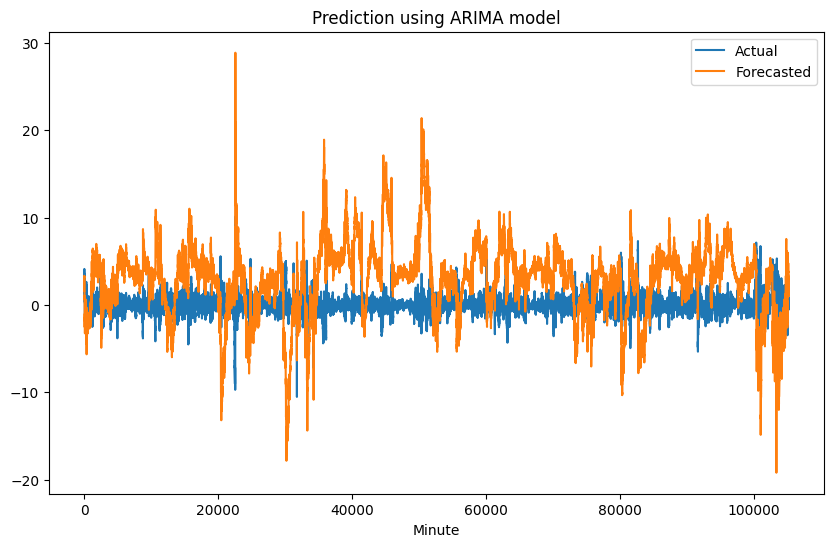

In [30]:
# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y_valid, label="Actual")
ax.plot(preds.to_numpy(), label="Forecasted")

ax.set_xlabel("Minute")
ax.set_title("Prediction using ARIMA model")
ax.legend()

Using the auto arima package

In [36]:
autoA = auto_arima(
  y_train,
  exogenous=X_train,
  start_p=1,
  start_q=1,
  max_p=5,
  max_q=5,
  d=1,
  D=3,
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True
)

/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=174.39 sec


/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-186662.320, Time=14.56 sec


/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-186662.756, Time=17.00 sec


/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-186662.914, Time=15.05 sec


/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-186664.320, Time=4.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 225.926 seconds


In [39]:
preds = autoA.predict(pd_X_valid.shape[0], X=pd_X_valid)

/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


---

# Temporal Fusion Transformer

\- Add Description -

In [1]:
import copy
import numpy as np
import torch
import polars as pl
import pandas as pd
import lightning.pytorch as ptl

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

torch.set_float32_matmul_precision("medium")

In [10]:
df_train = pl.read_csv('data/clean/pca_120.csv')
# df_train = df_train.with_columns(
#   pl.col('timestamp').str.to_datetime(time_unit='ns')
# )
df_train.head()

pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,…,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100,pca_101,pca_102,pca_103,pca_104,pca_105,pca_106,pca_107,pca_108,pca_109,pca_110,pca_111,pca_112,pca_113,pca_114,pca_115,pca_116,pca_117,pca_118,pca_119,pca_120,timestamp,label
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
-8.704309,5.45448,0.089441,-7.54084,4.768329,-5.736881,-0.231744,-1.788746,2.788266,-1.190636,3.148074,3.06826,6.837452,0.155804,-0.885875,-2.395842,3.13128,-4.266488,0.943026,0.60447,0.816785,-0.961067,-3.641479,-0.078829,-4.117839,4.6193,0.883802,-0.229885,0.600305,3.098696,-2.115549,1.951743,-0.103804,1.010359,1.52759,3.009872,0.625632,…,-0.83295,0.411902,1.958133,0.40939,0.075597,-1.114706,-0.102757,-0.103655,-0.173762,-0.167699,0.303377,-1.386903,0.9592,0.333935,-0.322841,0.100387,-0.00093,0.360481,-0.643133,-0.73806,0.887927,0.507611,-1.714703,-0.139313,-0.649024,-1.111647,-0.281171,0.62976,-1.064831,0.435178,0.168905,-0.654007,0.287436,-0.9085,-0.483989,"""2023-03-01T00:00:00.000000000""",0.562539
-7.994975,5.527279,-0.093258,-4.78567,4.097361,-6.208308,0.004089,-0.355855,3.798541,0.215877,2.648574,3.351467,6.158131,0.254169,-3.347221,-2.473193,3.618805,-3.161974,3.224999,2.054594,-2.296999,0.672556,-1.778871,-1.52334,1.743752,4.333566,-0.902184,0.029043,0.229918,2.181485,0.296175,1.67046,-0.227987,1.403915,2.228776,2.469899,-0.592644,…,-1.408637,0.337922,0.350379,-0.137153,0.000447,-1.546396,0.222861,0.54616,-0.286338,0.611064,-0.42617,-0.987761,1.431453,0.403918,-0.030256,0.113834,0.394106,-0.945749,-0.211975,-0.393696,1.696762,-0.206892,-2.071071,-0.696854,-0.789737,-0.818696,-0.342221,0.566906,-0.331511,0.761192,0.021027,-0.536371,-0.425608,0.056954,-0.552911,"""2023-03-01T00:01:00.000000000""",0.533686
-8.26279,5.052642,-0.215007,-4.022985,3.920973,-5.534213,-0.192796,1.0202,3.404864,1.268972,2.083842,3.41862,5.318265,-0.448951,-3.372344,-2.696721,3.405499,-1.909767,3.035536,2.726676,-2.895715,0.675317,-2.672765,-1.462927,4.68873,3.224458,-1.63386,-0.420518,0.737464,1.673416,1.288468,1.626087,-0.205033,1.21317,2.613173,1.760396,-0.513233,…,-1.435126,-0.602025,0.566827,0.197806,0.759271,-1.606877,-0.002562,-0.168767,-0.177104,-0.062822,0.693314,-1.088589,1.134069,-0.634355,0.603804,1.470887,1.181964,1.050156,0.296225,-0.416962,1.836099,-0.317207,-1.092388,-1.08504,-0.835654,-0.032517,-0.704754,-0.151475,0.02618,0.294466,-0.014631,-0.29039,-0.119407,-0.631851,-0.651055,"""2023-03-01T00:02:00.000000000""",0.546505
-6.583707,7.511057,-1.011146,-5.043764,4.93578,-5.846506,0.945893,-1.987165,5.037395,-0.61052,3.062758,3.185566,6.651355,0.209246,-4.044023,-2.209972,2.891386,-3.855405,3.003505,0.468633,-1.329728,0.101761,-1.862309,-2.455378,2.926416,4.623982,-2.465403,-0.558694,1.26826,1.792994,1.559252,2.209627,-0.713931,1.75982,1.519249,3.20797,-0.787381,…,-0.60509,-0.308904,0.684425,-0.057665,0.137066,-1.708174,-0.534534,0.067984,-0.612431,0.29722,0.05843,-1.00365,1.514464,-0.185545,0.080562,1.241688,0.870678,-0.031129,0.022311,-0.28331,1.933081,0.522886,-0.72863,-0.696465,-0.941094,-0.560078,-0.153947,1.394604,-0.566123,1.238746,0.415802,-0.680394,-0.322317,-0.24378,-0.658033,"""2023-03-01T00:03:00.000000000""",0.357703
-6.496762,7.126301,-0.582182,-5.279062,4.686467,-6.359052,0.802733,-0.713604,4.994975,0.220712,3.183836,2.947917,5.852149,-0.284797,-3.676434,-2.022073,2.813884,-2.542805,3.164651,2.014087,-1.716045,0.661284,-1.617872,-1.461303,2.399019,3.573622,-2.939042,-0.593127,1.061588,1.461763,1.08

In [11]:
PROJ_NAME = "drw_cryto_market"
SUBSET_PERC = 0.2
VAL_PERC = 0.1
MAX_ENC_LEN = 12
MAX_PRED_LEN = 12

# Model Params
ptl.seed_everything(43)
BATCH_SIZE = 128
LR = 0.0037153522909717258
HIDDEN_SIZE = 64
ATT_HEAD_SIZE = 16
DROPOUT = 0.1
HIDDEN_CONT_SIZE = 8

Seed set to 43


In [12]:
# Add a running time index and common group index
df_train = df_train.with_columns(
  group_idx=pl.Series([1] * df_train.shape[0]),
  time_idx=pl.Series(range(1, df_train.shape[0]+1)),
)
df_train = df_train.drop('timestamp')

# Uncomment to subset the training data to be smaller
subset_val = (1 - SUBSET_PERC) * df_train.shape[0]
subset_val = int(df_train.shape[0] - subset_val)
df_train = df_train.filter(pl.col('time_idx') < subset_val)

# Separate out a validation dataset
num_val = VAL_PERC * df_train.shape[0]
num_val = int(df_train.shape[0] - num_val)

df_valid = df_train.filter(pl.col('time_idx') > num_val)
df_train = df_train.filter(pl.col('time_idx') <= num_val)

# Convert both to pandas
df_train = df_train.to_pandas()
df_valid = df_valid.to_pandas()


In [13]:
df_train.shape, df_valid.shape

((94658, 123), (10518, 123))

In [18]:
# Creating the time series dataset
training = TimeSeriesDataSet(
  df_train,
  time_idx='time_idx',
  target='label',
  group_ids='group_idx',
  min_encoder_length=MAX_ENC_LEN,
  max_encoder_length=MAX_ENC_LEN,
  min_prediction_length=1,
  max_prediction_length=MAX_PRED_LEN,
  time_varying_known_categoricals=[],
  time_varying_known_reals=[],
  time_varying_unknown_categoricals=[],
  time_varying_unknown_reals=[i for i in df_train.columns if i not in ['group_idx', 'time_idx']],
  # target_normalizer=GroupNormalizer(
  #   groups=["group_idx"], transformation='softplus'
  # ),
  add_relative_time_idx=True,
  add_target_scales=True,
  add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(
  training, df_train, predict=True, stop_randomization=True
)

# Create data loader
train_dataloader = training.to_dataloader(
  train=True, batch_size=BATCH_SIZE, num_workers=0
)
val_dataloader = validation.to_dataloader(
  train=False, batch_size=BATCH_SIZE * 10, num_workers=0
)

Finding the optimal learning rate

In [10]:
# Configure network and training
trainer = ptl.Trainer(
  accelerator='gpu',
  gradient_clip_val=0.1
)

tft = TemporalFusionTransformer.from_dataset(
  training,
  learning_rate=LR,
  hidden_size=HIDDEN_SIZE,
  attention_head_size=ATT_HEAD_SIZE,
  dropout=DROPOUT,
  hidden_continuous_size=HIDDEN_CONT_SIZE,
  loss=QuantileLoss(),
  optimizer="ranger"
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 101.5k


/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-07-08 18:47:49.648000: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 18:47:49.959670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempti

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.0037153522909717258
Restoring states from the checkpoint path at /mnt/d/Projects/drw_crypto_market_prediction/.lr_find_9518e48b-1f17-45ef-a663-d2cdd48246c6.ckpt
Restored all states from the checkpoint at /mnt/d/Projects/drw_crypto_market_prediction/.lr_find_9518e48b-1f17-45ef-a663-d2cdd48246c6.ckpt


suggested learning rate: 0.0037153522909717258


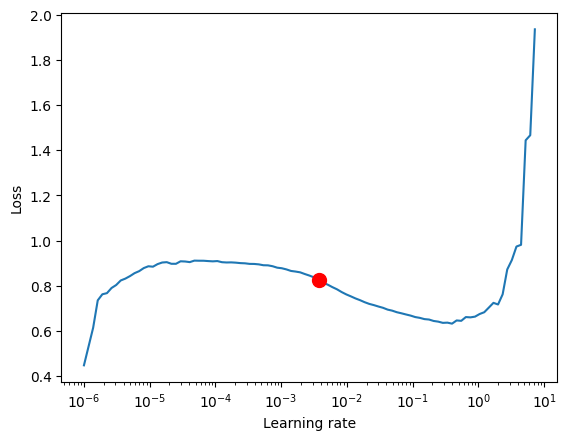

/tmp/ipykernel_9099/3396776692.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [11]:
res = Tuner(trainer).lr_find(
  tft,
  train_dataloaders=train_dataloader,
  val_dataloaders=val_dataloader,
  max_lr=10.0,
  min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Configure the network and train

In [15]:
from lightning.pytorch.loggers import WandbLogger
# Define model configurations

# Define the Wandb logger
wandb_logger = WandbLogger(
  log_model=False,
  project=PROJ_NAME,
  notes="Temporal Fusion Transformer with pca_120 data",
  tags=["transformer", "pca_120"],
  config={
    'max_encoder_length': MAX_ENC_LEN,
    'max_prediction_length': MAX_PRED_LEN,
    'batch_size': BATCH_SIZE,
    'learning_rate': LR,
    'hidden_size': HIDDEN_SIZE,
    'attention_head_size': ATT_HEAD_SIZE,
    'dropout': DROPOUT,
    'hidden_continuous_size': HIDDEN_CONT_SIZE
  }
)

In [16]:
wandb_logger.experiment.project

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: minimartzz to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


'drw_cryto_market'

In [19]:
# Configure the network and trainer
early_stop_callback = EarlyStopping(
  monitor='val_loss',
  min_delta=1e-4,
  patience=10,
  verbose=False,
  mode="min"
)
lr_logger = LearningRateMonitor()

trainer = ptl.Trainer(
  max_epochs=30,
  accelerator='gpu',
  enable_model_summary=True,
  gradient_clip_val=0.1,
  limit_train_batches=50,
  # callbacks=[lr_logger, early_stop_callback]
  # logger=wandb_logger
)

tft = TemporalFusionTransformer.from_dataset(
  training,
  learning_rate=LR,
  hidden_size=HIDDEN_SIZE,
  attention_head_size=ATT_HEAD_SIZE,
  dropout=DROPOUT,
  hidden_continuous_size=HIDDEN_CONT_SIZE,
  loss=QuantileLoss(),
  log_interval=10,
  optimizer='ranger',
  reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 498.9k


In [20]:
# Fit network
trainer.fit(
  tft,
  train_dataloaders=train_dataloader,
  val_dataloaders=val_dataloader
)

2025-07-08 18:59:11.289943: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 18:59:11.458581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751972351.515256   11414 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751972351.530675   11414 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751972351.660413   11414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [30]:
# Uncomment to disable logging
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)

In [46]:
# Evaluation
s1 = df_train.tail(MAX_ENC_LEN)
evaluation = pd.concat([s1, df_valid], axis=0)

start_idx = MAX_ENC_LEN
preds = []
pred_size = 0
c = 0

while pred_size < len(df_valid):
  print(f"Completed: {pred_size} / {df_valid.shape[0]} ({round(pred_size/df_valid.shape[0], 2)})")

  pred_set = evaluation.iloc[c:c+start_idx+MAX_PRED_LEN]

  # Make prediction
  predictions = tft.predict(
    pred_set,
    mode='prediction',
    return_x=True,
    trainer_kwargs=dict(accelerator="gpu"),
  )
  pred = predictions.output[0].tolist()
  preds.append(pred)

  pred_size += MAX_PRED_LEN
  c += 1


# for i in range(df_valid.shape[0]):
#   # Subset the prediction
#   pred_set = evaluation.iloc[i:i+start_idx+MAX_PRED_LEN]

#   # Make prediction
#   predictions = tft.predict(
#     pred_set,
#     mode='prediction',
#     return_x=True,
#     trainer_kwargs=dict(accelerator="gpu"),
#   )
#   pred = predictions.output[0].tolist()
#   preds.append(pred)

#   if i % 100 == 0:
#     print(f"Completed: {i} / {df_valid.shape[0]} ({round(i/df_valid.shape[0], 2)})")
#     print(f"Original: {pred_set['label'][i]}; Predicted: {pred}") 

Completed: 0 / 10518 (0.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 12 / 10518 (0.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 24 / 10518 (0.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 36 / 10518 (0.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 48 / 10518 (0.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 60 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 72 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 84 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 96 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 108 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 120 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 132 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 144 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 156 / 10518 (0.01)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 168 / 10518 (0.02)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 180 / 10518 (0.02)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 192 / 10518 (0.02)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 204 / 10518 (0.02)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 216 / 10518 (0.02)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 228 / 10518 (0.02)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 240 / 10518 (0.02)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 252 / 10518 (0.02)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 264 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 276 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 288 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 300 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 312 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 324 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 336 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 348 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 360 / 10518 (0.03)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 372 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 384 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 396 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 408 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 420 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 432 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 444 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 456 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 468 / 10518 (0.04)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 480 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 492 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 504 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 516 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 528 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 540 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 552 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 564 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 576 / 10518 (0.05)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 588 / 10518 (0.06)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 600 / 10518 (0.06)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 612 / 10518 (0.06)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 624 / 10518 (0.06)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 636 / 10518 (0.06)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 648 / 10518 (0.06)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 660 / 10518 (0.06)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 672 / 10518 (0.06)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 684 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 696 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 708 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 720 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 732 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 744 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 756 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 768 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 780 / 10518 (0.07)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 792 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 804 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 816 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 828 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 840 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 852 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 864 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 876 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 888 / 10518 (0.08)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 900 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 912 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 924 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 936 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 948 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 960 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 972 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 984 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 996 / 10518 (0.09)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1008 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1020 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1032 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1044 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1056 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1068 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1080 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1092 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1104 / 10518 (0.1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1116 / 10518 (0.11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1128 / 10518 (0.11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1140 / 10518 (0.11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1152 / 10518 (0.11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1164 / 10518 (0.11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1176 / 10518 (0.11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1188 / 10518 (0.11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1200 / 10518 (0.11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1212 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1224 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1236 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1248 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1260 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1272 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1284 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1296 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1308 / 10518 (0.12)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1320 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1332 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1344 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1356 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1368 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1380 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1392 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1404 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1416 / 10518 (0.13)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1428 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1440 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1452 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1464 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1476 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1488 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1500 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1512 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1524 / 10518 (0.14)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1536 / 10518 (0.15)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1548 / 10518 (0.15)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1560 / 10518 (0.15)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1572 / 10518 (0.15)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1584 / 10518 (0.15)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1596 / 10518 (0.15)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1608 / 10518 (0.15)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1620 / 10518 (0.15)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1632 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1644 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1656 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1668 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1680 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1692 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1704 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1716 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1728 / 10518 (0.16)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1740 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1752 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1764 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1776 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1788 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1800 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1812 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1824 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1836 / 10518 (0.17)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1848 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1860 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1872 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1884 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1896 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1908 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1920 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1932 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1944 / 10518 (0.18)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1956 / 10518 (0.19)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1968 / 10518 (0.19)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1980 / 10518 (0.19)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 1992 / 10518 (0.19)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2004 / 10518 (0.19)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2016 / 10518 (0.19)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2028 / 10518 (0.19)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2040 / 10518 (0.19)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2052 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2064 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2076 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2088 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2100 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2112 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2124 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2136 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2148 / 10518 (0.2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2160 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2172 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2184 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2196 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2208 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2220 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2232 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2244 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2256 / 10518 (0.21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2268 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2280 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2292 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2304 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2316 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2328 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2340 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2352 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2364 / 10518 (0.22)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2376 / 10518 (0.23)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2388 / 10518 (0.23)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2400 / 10518 (0.23)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2412 / 10518 (0.23)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2424 / 10518 (0.23)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2436 / 10518 (0.23)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2448 / 10518 (0.23)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2460 / 10518 (0.23)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2472 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2484 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2496 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2508 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2520 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2532 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2544 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2556 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2568 / 10518 (0.24)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2580 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2592 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2604 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2616 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2628 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2640 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2652 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2664 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2676 / 10518 (0.25)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2688 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2700 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2712 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2724 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2736 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2748 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2760 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2772 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2784 / 10518 (0.26)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2796 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2808 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2820 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2832 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2844 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2856 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2868 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2880 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2892 / 10518 (0.27)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2904 / 10518 (0.28)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2916 / 10518 (0.28)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2928 / 10518 (0.28)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2940 / 10518 (0.28)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2952 / 10518 (0.28)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2964 / 10518 (0.28)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2976 / 10518 (0.28)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 2988 / 10518 (0.28)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3000 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3012 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3024 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3036 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3048 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3060 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3072 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3084 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3096 / 10518 (0.29)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3108 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3120 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3132 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3144 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3156 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3168 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3180 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3192 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3204 / 10518 (0.3)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3216 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3228 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3240 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3252 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3264 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3276 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3288 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3300 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3312 / 10518 (0.31)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3324 / 10518 (0.32)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3336 / 10518 (0.32)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3348 / 10518 (0.32)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3360 / 10518 (0.32)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3372 / 10518 (0.32)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3384 / 10518 (0.32)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3396 / 10518 (0.32)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3408 / 10518 (0.32)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3420 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3432 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3444 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3456 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3468 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3480 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3492 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3504 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3516 / 10518 (0.33)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3528 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3540 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3552 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3564 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3576 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3588 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3600 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3612 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3624 / 10518 (0.34)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3636 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3648 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3660 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3672 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3684 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3696 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3708 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3720 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3732 / 10518 (0.35)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3744 / 10518 (0.36)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3756 / 10518 (0.36)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3768 / 10518 (0.36)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3780 / 10518 (0.36)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3792 / 10518 (0.36)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3804 / 10518 (0.36)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3816 / 10518 (0.36)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3828 / 10518 (0.36)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3840 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3852 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3864 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3876 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3888 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3900 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3912 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3924 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3936 / 10518 (0.37)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3948 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3960 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3972 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3984 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 3996 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4008 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4020 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4032 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4044 / 10518 (0.38)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4056 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4068 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4080 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4092 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4104 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4116 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4128 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4140 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4152 / 10518 (0.39)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4164 / 10518 (0.4)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4176 / 10518 (0.4)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4188 / 10518 (0.4)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4200 / 10518 (0.4)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4212 / 10518 (0.4)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4224 / 10518 (0.4)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4236 / 10518 (0.4)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4248 / 10518 (0.4)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4260 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4272 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4284 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4296 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4308 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4320 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4332 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4344 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4356 / 10518 (0.41)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4368 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4380 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4392 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4404 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4416 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4428 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4440 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4452 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4464 / 10518 (0.42)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4476 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4488 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4500 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4512 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4524 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4536 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4548 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4560 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4572 / 10518 (0.43)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4584 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4596 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4608 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4620 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4632 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4644 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4656 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4668 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4680 / 10518 (0.44)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4692 / 10518 (0.45)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4704 / 10518 (0.45)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4716 / 10518 (0.45)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4728 / 10518 (0.45)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4740 / 10518 (0.45)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4752 / 10518 (0.45)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4764 / 10518 (0.45)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4776 / 10518 (0.45)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4788 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4800 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4812 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4824 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4836 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4848 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4860 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4872 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4884 / 10518 (0.46)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4896 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4908 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4920 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4932 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4944 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4956 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4968 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4980 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 4992 / 10518 (0.47)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5004 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5016 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5028 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5040 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5052 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5064 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5076 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5088 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5100 / 10518 (0.48)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5112 / 10518 (0.49)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5124 / 10518 (0.49)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5136 / 10518 (0.49)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5148 / 10518 (0.49)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5160 / 10518 (0.49)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5172 / 10518 (0.49)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5184 / 10518 (0.49)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5196 / 10518 (0.49)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5208 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5220 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5232 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5244 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5256 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5268 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5280 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5292 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5304 / 10518 (0.5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5316 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5328 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5340 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5352 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5364 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5376 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5388 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5400 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5412 / 10518 (0.51)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5424 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5436 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5448 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5460 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5472 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5484 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5496 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5508 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5520 / 10518 (0.52)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5532 / 10518 (0.53)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5544 / 10518 (0.53)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5556 / 10518 (0.53)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5568 / 10518 (0.53)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5580 / 10518 (0.53)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5592 / 10518 (0.53)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5604 / 10518 (0.53)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5616 / 10518 (0.53)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5628 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5640 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5652 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5664 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5676 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5688 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5700 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5712 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5724 / 10518 (0.54)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5736 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5748 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5760 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5772 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5784 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5796 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5808 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5820 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5832 / 10518 (0.55)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5844 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5856 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5868 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5880 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5892 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5904 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5916 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5928 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5940 / 10518 (0.56)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5952 / 10518 (0.57)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5964 / 10518 (0.57)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5976 / 10518 (0.57)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 5988 / 10518 (0.57)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6000 / 10518 (0.57)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6012 / 10518 (0.57)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6024 / 10518 (0.57)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6036 / 10518 (0.57)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6048 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6060 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6072 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6084 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6096 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6108 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6120 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6132 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6144 / 10518 (0.58)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6156 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6168 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6180 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6192 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6204 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6216 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6228 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6240 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6252 / 10518 (0.59)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6264 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6276 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6288 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6300 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6312 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6324 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6336 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6348 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6360 / 10518 (0.6)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6372 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6384 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6396 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6408 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6420 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6432 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6444 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6456 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6468 / 10518 (0.61)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6480 / 10518 (0.62)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6492 / 10518 (0.62)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6504 / 10518 (0.62)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6516 / 10518 (0.62)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6528 / 10518 (0.62)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6540 / 10518 (0.62)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6552 / 10518 (0.62)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6564 / 10518 (0.62)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6576 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6588 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6600 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6612 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6624 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6636 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6648 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6660 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6672 / 10518 (0.63)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6684 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6696 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6708 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6720 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6732 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6744 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6756 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6768 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6780 / 10518 (0.64)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6792 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6804 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6816 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6828 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6840 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6852 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6864 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6876 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6888 / 10518 (0.65)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6900 / 10518 (0.66)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6912 / 10518 (0.66)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6924 / 10518 (0.66)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6936 / 10518 (0.66)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6948 / 10518 (0.66)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6960 / 10518 (0.66)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6972 / 10518 (0.66)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6984 / 10518 (0.66)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 6996 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7008 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7020 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7032 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7044 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7056 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7068 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7080 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7092 / 10518 (0.67)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7104 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7116 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7128 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7140 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7152 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7164 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7176 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7188 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7200 / 10518 (0.68)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7212 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7224 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7236 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7248 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7260 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7272 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7284 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7296 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7308 / 10518 (0.69)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7320 / 10518 (0.7)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7332 / 10518 (0.7)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7344 / 10518 (0.7)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7356 / 10518 (0.7)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7368 / 10518 (0.7)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7380 / 10518 (0.7)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7392 / 10518 (0.7)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7404 / 10518 (0.7)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7416 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7428 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7440 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7452 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7464 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7476 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7488 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7500 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7512 / 10518 (0.71)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7524 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7536 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7548 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7560 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7572 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7584 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7596 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7608 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7620 / 10518 (0.72)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7632 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7644 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7656 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7668 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7680 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7692 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7704 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7716 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7728 / 10518 (0.73)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7740 / 10518 (0.74)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7752 / 10518 (0.74)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7764 / 10518 (0.74)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7776 / 10518 (0.74)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7788 / 10518 (0.74)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7800 / 10518 (0.74)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7812 / 10518 (0.74)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7824 / 10518 (0.74)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7836 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7848 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7860 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7872 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7884 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7896 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7908 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7920 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7932 / 10518 (0.75)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7944 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7956 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7968 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7980 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 7992 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8004 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8016 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8028 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8040 / 10518 (0.76)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8052 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8064 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8076 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8088 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8100 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8112 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8124 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8136 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8148 / 10518 (0.77)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8160 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8172 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8184 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8196 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8208 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8220 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8232 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8244 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8256 / 10518 (0.78)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8268 / 10518 (0.79)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8280 / 10518 (0.79)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8292 / 10518 (0.79)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8304 / 10518 (0.79)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8316 / 10518 (0.79)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8328 / 10518 (0.79)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8340 / 10518 (0.79)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8352 / 10518 (0.79)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8364 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8376 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8388 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8400 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8412 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8424 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8436 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8448 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8460 / 10518 (0.8)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8472 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8484 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8496 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8508 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8520 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8532 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8544 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8556 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8568 / 10518 (0.81)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8580 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8592 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8604 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8616 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8628 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8640 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8652 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8664 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8676 / 10518 (0.82)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8688 / 10518 (0.83)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8700 / 10518 (0.83)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8712 / 10518 (0.83)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8724 / 10518 (0.83)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8736 / 10518 (0.83)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8748 / 10518 (0.83)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8760 / 10518 (0.83)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8772 / 10518 (0.83)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8784 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8796 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8808 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8820 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8832 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8844 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8856 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8868 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8880 / 10518 (0.84)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8892 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8904 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8916 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8928 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8940 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8952 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8964 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8976 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 8988 / 10518 (0.85)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9000 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9012 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9024 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9036 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9048 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9060 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9072 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9084 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9096 / 10518 (0.86)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9108 / 10518 (0.87)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9120 / 10518 (0.87)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9132 / 10518 (0.87)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9144 / 10518 (0.87)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9156 / 10518 (0.87)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9168 / 10518 (0.87)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9180 / 10518 (0.87)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9192 / 10518 (0.87)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9204 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9216 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9228 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9240 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9252 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9264 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9276 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9288 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9300 / 10518 (0.88)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9312 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9324 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9336 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9348 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9360 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9372 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9384 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9396 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9408 / 10518 (0.89)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9420 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9432 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9444 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9456 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9468 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9480 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9492 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9504 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9516 / 10518 (0.9)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9528 / 10518 (0.91)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9540 / 10518 (0.91)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9552 / 10518 (0.91)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9564 / 10518 (0.91)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9576 / 10518 (0.91)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9588 / 10518 (0.91)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9600 / 10518 (0.91)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9612 / 10518 (0.91)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9624 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9636 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9648 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9660 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9672 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9684 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9696 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9708 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9720 / 10518 (0.92)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9732 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9744 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9756 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9768 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9780 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9792 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9804 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9816 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9828 / 10518 (0.93)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9840 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9852 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9864 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9876 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9888 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9900 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9912 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9924 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9936 / 10518 (0.94)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9948 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9960 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9972 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9984 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 9996 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10008 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10020 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10032 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10044 / 10518 (0.95)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10056 / 10518 (0.96)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10068 / 10518 (0.96)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10080 / 10518 (0.96)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10092 / 10518 (0.96)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10104 / 10518 (0.96)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10116 / 10518 (0.96)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10128 / 10518 (0.96)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10140 / 10518 (0.96)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10152 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10164 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10176 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10188 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10200 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10212 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10224 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10236 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10248 / 10518 (0.97)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10260 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10272 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10284 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10296 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10308 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10320 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10332 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10344 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10356 / 10518 (0.98)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10368 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10380 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10392 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10404 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10416 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10428 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10440 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10452 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10464 / 10518 (0.99)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10476 / 10518 (1.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10488 / 10518 (1.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10500 / 10518 (1.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Completed: 10512 / 10518 (1.0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Tested but this method does not scale well for prediction

---

# Make Predictions

In [ ]:
test = pl.read_csv("./data/clean/test_plus.csv")

test = test.drop(['timestamp', 'label'])
test = test.to_numpy()
test = scaler.transform(test)

In [23]:
model = LGBMRegressor()
model.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.592967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223360
[LightGBM] [Info] Number of data points in the train set: 525887, number of used features: 876
[LightGBM] [Info] Start training from score 0.036126


LGBMRegressor()

In [24]:
preds = model.predict(test)

d:\Software\venv\py311_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [27]:
pl.DataFrame({
  "ID": range(1, 1+len(test)), 
  "prediction": preds
}).write_csv("results/baseline.csv")